In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules import transformer
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import torch.optim as optim
from torchvision import transforms
import pandas as pd
import os
import argparse

c:\Users\Tree\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

   

    return train_data, train_label, test_data, test_label

def testing(x_test,y_test,model,device):
    model.eval()
    with torch.no_grad():
        model.cuda(0)
        n = x_test.shape[0]

        x_test = x_test.astype("float32")
        y_test = y_test.astype("float32").reshape(y_test.shape[0],)

        x_test, y_test = Variable(torch.from_numpy(x_test)),Variable(torch.from_numpy(y_test))
        x_test,y_test = x_test.to(device),y_test.to(device)
        y_pred_test = model(x_test)
        correct = (torch.max(y_pred_test,1)[1]==y_test).sum().item()
        # print("testing accuracy:",correct/n)
    return correct/n


In [20]:
train_data, train_label, test_data, test_label = read_bci_data()

n = train_data.shape[0]
# epochs = 3000

device = torch.device("cuda:0")

train_data = train_data.astype("float32")
train_label = train_label.astype("float32").reshape(train_label.shape[0],)

# train_data.shape = (1080,1,2,750)
# train_label.shape = (1080,)

x, y = Variable(torch.from_numpy(train_data)),Variable(torch.from_numpy(train_label))
y=torch.tensor(y, dtype=torch.long) 

class EEGNetELU(torch.nn.Module):
    def __init__(self):
        super(EEGNetELU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class EEGNetReLU(nn.Module):
    def __init__(self):
        super(EEGNetReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class EEGNetLeakyReLU(nn.Module):
    def __init__(self):
        super(EEGNetLeakyReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out
    
class EEGNetLeakyReLUsoftmax(nn.Module):
    def __init__(self):
        super(EEGNetLeakyReLUsoftmax, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.06),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736,2,bias=True),
            nn.Softmax()
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out) 
        out = self.classify(out)
        return out

C:\Users\Tree\AppData\Local\Temp\ipykernel_32036\2870141004.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, dtype=torch.long)


In [4]:
epochs = 1000
lr = 1e-3
ELU_max_val_acc = 0
model = EEGNetELU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400,500,700], gamma=0.5)

model.to(device)

loss_history = []
ELU_train_accuracy_history = []
ELU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,y = x.to(device),y.to(device)
    y_pred = model(x)

    loss = criterion(y_pred, y)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        ELU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        ELU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > ELU_max_val_acc:
            ELU_max_val_acc = test_accuracy

print("Max accuracy:",ELU_max_val_acc)

epochs: 0 loss: 0.7491865158081055 Training Accuracy: 0.4287037037037037 Testing Accuracy: 0.575 Learning rate: 0.001
epochs: 1 loss: 0.6765149235725403 Training Accuracy: 0.6111111111111112 Testing Accuracy: 0.674074074074074 Learning rate: 0.001
epochs: 2 loss: 0.6740570068359375 Training Accuracy: 0.6907407407407408 Testing Accuracy: 0.6953703703703704 Learning rate: 0.001
epochs: 3 loss: 0.5808196067810059 Training Accuracy: 0.7083333333333334 Testing Accuracy: 0.7 Learning rate: 0.001
epochs: 4 loss: 0.5516947507858276 Training Accuracy: 0.7129629629629629 Testing Accuracy: 0.6638888888888889 Learning rate: 0.001
epochs: 5 loss: 0.5428352952003479 Training Accuracy: 0.7222222222222222 Testing Accuracy: 0.7101851851851851 Learning rate: 0.001
epochs: 6 loss: 0.5104250907897949 Training Accuracy: 0.75 Testing Accuracy: 0.7064814814814815 Learning rate: 0.001
epochs: 7 loss: 0.4823247790336609 Training Accuracy: 0.7666666666666667 Testing Accuracy: 0.7037037037037037 Learning rate: 0

In [41]:
epochs = 1000
lr = 1e-3
ReLU_max_val_acc = 0
model = EEGNetLeakyReLUsoftmax()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400,500,700], gamma=0.5)

model.to(device)


yhat = np.eye(2)[y.cpu()]
yhat=torch.tensor(yhat).float()

loss_history = []
ReLU_train_accuracy_history = []
ReLU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,yhat = x.to(device),yhat.to(device)
    y_pred = model(x)
    # print(yhat.shape)

    loss = criterion(y_pred, yhat)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        ReLU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        ReLU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > ReLU_max_val_acc:
            ReLU_max_val_acc = test_accuracy

print("Max accuracy:",ReLU_max_val_acc)

epochs: 0 loss: 0.2715959846973419 Training Accuracy: 0.4546296296296296 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 1 loss: 0.44391533732414246 Training Accuracy: 0.5 Testing Accuracy: 0.5175925925925926 Learning rate: 0.001
epochs: 2 loss: 0.27291229367256165 Training Accuracy: 0.5972222222222222 Testing Accuracy: 0.6055555555555555 Learning rate: 0.001
epochs: 3 loss: 0.3075293004512787 Training Accuracy: 0.5731481481481482 Testing Accuracy: 0.6555555555555556 Learning rate: 0.001
epochs: 4 loss: 0.23156701028347015 Training Accuracy: 0.6537037037037037 Testing Accuracy: 0.6944444444444444 Learning rate: 0.001
epochs: 5 loss: 0.19852252304553986 Training Accuracy: 0.7046296296296296 Testing Accuracy: 0.6768518518518518 Learning rate: 0.001
epochs: 6 loss: 0.19994275271892548 Training Accuracy: 0.7018518518518518 Testing Accuracy: 0.7194444444444444 Learning rate: 0.001
epochs: 7 loss: 0.18726110458374023 Training Accuracy: 0.7277777777777777 Testing Accuracy: 0.72314814814814

In [49]:
epochs = 1000
lr = 1e-2
ReLU_max_val_acc = 0
model = EEGNetLeakyReLU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400,500,700], gamma=0.5)

model.to(device)


yhat = np.eye(2)[y.cpu()]
yhat=torch.tensor(yhat).float()

loss_history = []
ReLU_train_accuracy_history = []
ReLU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,yhat = x.to(device),yhat.to(device)
    y_pred = model(x)
    # print(yhat.shape)

    loss = criterion(y_pred, yhat)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        ReLU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        ReLU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > ReLU_max_val_acc:
            ReLU_max_val_acc = test_accuracy

print("Max accuracy:",ReLU_max_val_acc)

epochs: 0 loss: 0.7109530568122864 Training Accuracy: 0.49722222222222223 Testing Accuracy: 0.5 Learning rate: 0.01
epochs: 1 loss: 9.49557113647461 Training Accuracy: 0.5 Testing Accuracy: 0.5018518518518519 Learning rate: 0.01
epochs: 2 loss: 6.502099514007568 Training Accuracy: 0.5120370370370371 Testing Accuracy: 0.6166666666666667 Learning rate: 0.01
epochs: 3 loss: 1.5915991067886353 Training Accuracy: 0.6555555555555556 Testing Accuracy: 0.5787037037037037 Learning rate: 0.01
epochs: 4 loss: 2.055659770965576 Training Accuracy: 0.6351851851851852 Testing Accuracy: 0.6555555555555556 Learning rate: 0.01
epochs: 5 loss: 1.1146867275238037 Training Accuracy: 0.6731481481481482 Testing Accuracy: 0.5907407407407408 Learning rate: 0.01
epochs: 6 loss: 1.2495478391647339 Training Accuracy: 0.6231481481481481 Testing Accuracy: 0.6324074074074074 Learning rate: 0.01
epochs: 7 loss: 0.8818430304527283 Training Accuracy: 0.7046296296296296 Testing Accuracy: 0.6574074074074074 Learning rate

In [42]:
epochs = 1000
lr = 1e-3
LeakyReLU_max_val_acc = 0
model = EEGNetLeakyReLU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400,500,700], gamma=0.5)

model.to(device)

loss_history = []
LeakyReLU_train_accuracy_history = []
LeakyReLU_test_accuracy_history = []
for epoch in range(epochs):
    # for idx,(data,target) in enumerate(loader):
    model.train()
    x,y = x.to(device),y.to(device)
    y_pred = model(x)

    loss = criterion(y_pred, y)
    train_loss = loss.item()
    loss_history.append(train_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%1==0:

        # correct= (y_pred.ge(0.5) == y).sum().item()
        n = y.shape[0]
        correct = (torch.max(y_pred,1)[1]==y).sum().item()
        train_accuracy = correct / n
        LeakyReLU_train_accuracy_history.append(train_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"Accuracy:",(correct / n),"Learning rate:",scheduler.get_last_lr()[0])
        test_accuracy = testing(test_data,test_label,model,device)
        LeakyReLU_test_accuracy_history.append(test_accuracy)

        print("epochs:",epoch,"loss:",train_loss,"Training Accuracy:",train_accuracy,"Testing Accuracy:",test_accuracy,"Learning rate:",scheduler.get_last_lr()[0])
        
        if test_accuracy > LeakyReLU_max_val_acc:
            LeakyReLU_max_val_acc = test_accuracy

print("Max accuracy:",LeakyReLU_max_val_acc)


epochs: 0 loss: 0.7260696291923523 Training Accuracy: 0.49444444444444446 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 1 loss: 2.009072780609131 Training Accuracy: 0.5 Testing Accuracy: 0.5342592592592592 Learning rate: 0.001
epochs: 2 loss: 0.7540302872657776 Training Accuracy: 0.5740740740740741 Testing Accuracy: 0.5 Learning rate: 0.001
epochs: 3 loss: 1.1523690223693848 Training Accuracy: 0.5018518518518519 Testing Accuracy: 0.5157407407407407 Learning rate: 0.001
epochs: 4 loss: 0.7716735005378723 Training Accuracy: 0.575 Testing Accuracy: 0.6851851851851852 Learning rate: 0.001
epochs: 5 loss: 0.5893934965133667 Training Accuracy: 0.6805555555555556 Testing Accuracy: 0.6537037037037037 Learning rate: 0.001
epochs: 6 loss: 0.6478205919265747 Training Accuracy: 0.6574074074074074 Testing Accuracy: 0.7027777777777777 Learning rate: 0.001
epochs: 7 loss: 0.5628387331962585 Training Accuracy: 0.700925925925926 Testing Accuracy: 0.6907407407407408 Learning rate: 0.001
epochs: 8 l

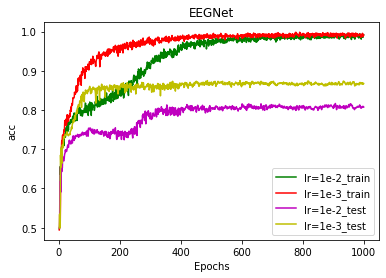

EEGNet with lr=1e-2           Max test Acc  = 0.8166666666666667
EEGNet with lr=1e-3           Max test Acc  = 0.875


In [50]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch

epochs = range(1, len(ReLU_train_accuracy_history) + 1)
# plt.plot(epochs, ELU_train_accuracy_history, label='ELU_train', color='b')
plt.plot(epochs, ReLU_train_accuracy_history, label='lr=1e-2_train', color='g')
plt.plot(epochs, LeakyReLU_train_accuracy_history, label='lr=1e-3_train', color='r')
# plt.plot(epochs, ELU_test_accuracy_history, label='ELU_test', color='c')
plt.plot(epochs, ReLU_test_accuracy_history, label='lr=1e-2_test', color='m')
plt.plot(epochs, LeakyReLU_test_accuracy_history, label='lr=1e-3_test', color='y')
plt.title('EEGNet')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

# print(f"{'EEGNet with ELU' : <27}{'Max test Acc' : <14}{'= '}{ELU_max_val_acc}")
print(f"{'EEGNet with lr=1e-2' : <30}{'Max test Acc' : <14}{'= '}{ReLU_max_val_acc}")
print(f"{'EEGNet with lr=1e-3' : <30}{'Max test Acc' : <14}{'= '}{LeakyReLU_max_val_acc}")